In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [4]:
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('pets', target_types='segmentation', download=True)

100%|██████████| 791918971/791918971 [00:37<00:00, 20977456.43it/s]


Extracting pets/oxford-iiit-pet/images.tar.gz to pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10559254.27it/s]


Extracting pets/oxford-iiit-pet/annotations.tar.gz to pets/oxford-iiit-pet


In [5]:
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

In [6]:
train_dataset = OxfordIIITPet('pets', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [8]:
np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200)

In [9]:
valid_dataset = torch.utils.data.Subset(valid_dataset, idx)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=200, shuffle=False)

In [10]:
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [11]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [12]:
#!g1.1
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [13]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        

In [14]:
import torch
import torch.nn as nn

def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )

class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)
        
        self.up1 = conv_plus_conv(base_channels * 32,base_channels * 8)
        self.up2 = conv_plus_conv(base_channels * 16, base_channels * 4)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 4, base_channels)
        self.up5 = conv_plus_conv(base_channels * 2, base_channels)
        self.bottleneck = conv_plus_conv(base_channels * 16, base_channels * 16)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        residual1 = self.down1(x) # x.shape: (N, N, 3) -> (N, N, base_channels)  
        x = self.downsample(residual1) # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)
        
        residual2 = self.down2(x) # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2) # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
        
        residual3 = self.down3(x) # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 4)
        x = self.downsample(residual3) # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)
        
        residual4 = self.down4(x) # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 8)
        x = self.downsample(residual4) # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 16, N // 16, base_channels * 8)
        
        residual5 = self.down5(x) # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 16, N // 16, base_channels * 16)
        x = self.downsample(residual5) # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)
        
        x = self.bottleneck(x) # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)
        
        
        x = nn.functional.interpolate(x, scale_factor=2) # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 16, N // 16, base_channels * 16)
        x = torch.cat((x, residual5), dim=1) # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 16, N // 16, base_channels * 32)
        x = self.up1(x) # x.shape: (N // 16, N // 16, base_channels * 32) -> (N // 16, N // 16, base_channels * 16)

        x = nn.functional.interpolate(x, scale_factor=2) # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 8, N // 8, base_channels * 16)
        x = torch.cat((x, residual4), dim=1) # x.shape: (N // 8, N // 8, base_channels * 16) -> (N // 8, N // 8, base_channels * 32)
        x = self.up2(x)

        x = nn.functional.interpolate(x, scale_factor=2) 
        x = torch.cat((x, residual3), dim=1) 
        x = self.up3(x) 

        x = nn.functional.interpolate(x, scale_factor=2) 
        x = torch.cat((x, residual2), dim=1) 
        x = self.up4(x) 

        x = nn.functional.interpolate(x, scale_factor=2) 
        x = torch.cat((x, residual1), dim=1) 
        x = self.up5(x) 

        x = self.out(x) 

        return x


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


In [16]:
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

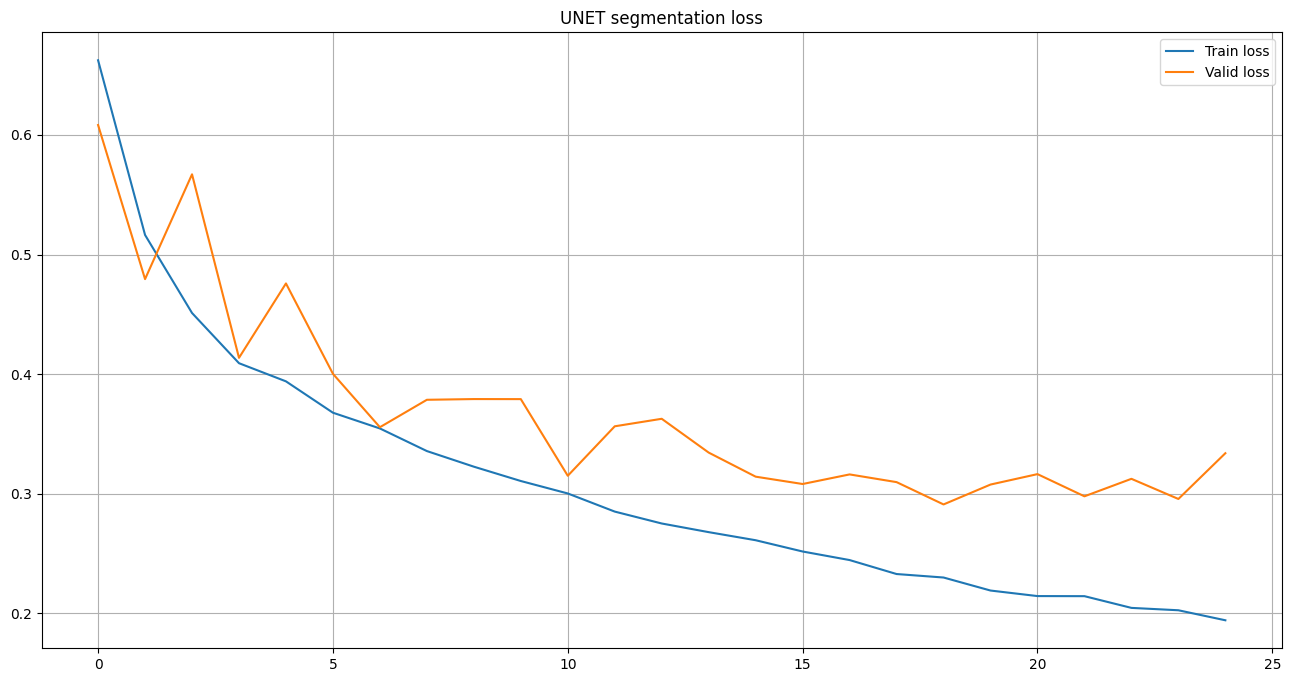

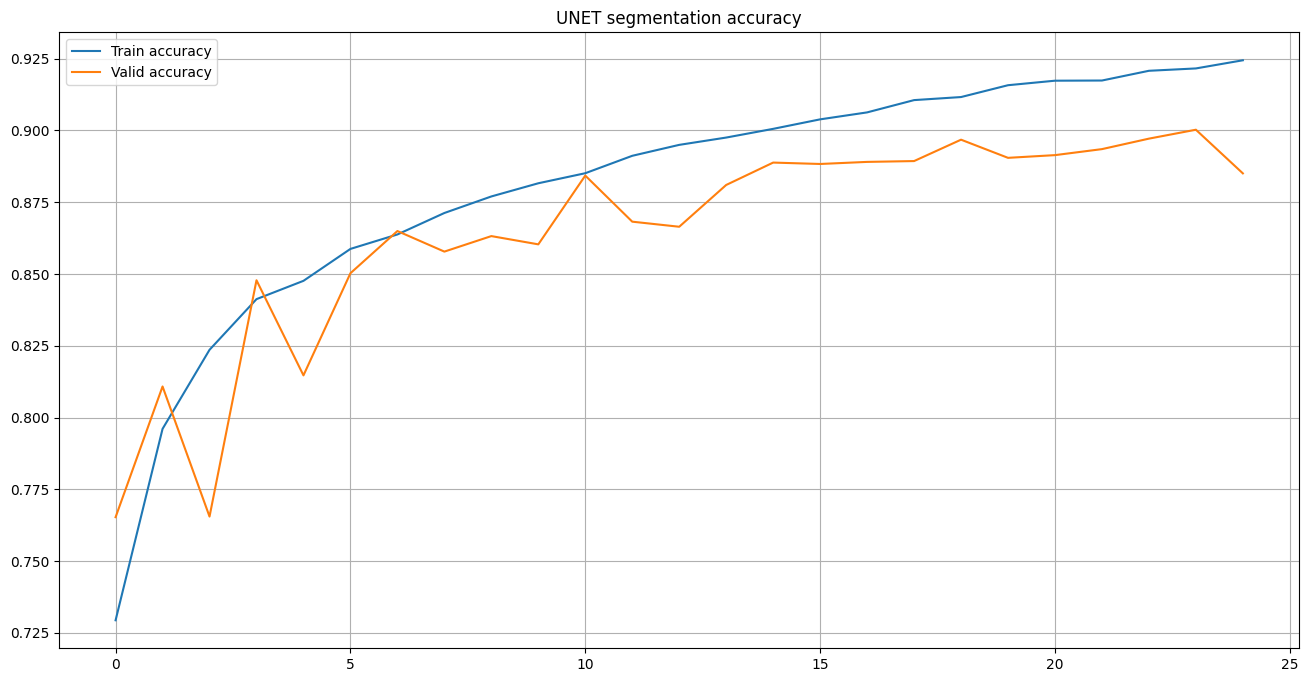

In [17]:
whole_train_valid_cycle(model, 25, 'UNET segmentation')

In [20]:
predictions = []

with torch.no_grad():
    for images, _ in valid_loader:

        images = images.to(device)

        outputs = model(images)

        # outputs = torch.mean(outputs, dim=1, keepdim=True) - было
        outputs = torch.argmax(outputs, dim=1, keepdim=True) 

        outputs = outputs.to(torch.uint8)

        predictions.append(outputs.cpu())

predictions_unit8 = torch.cat(predictions, dim=0)

print(predictions_unit8.shape)

torch.Size([200, 1, 256, 256])


In [21]:
torch.save(predictions_unit8, 'predictions.pt')